# Solving the harmonic oscillator with a finite duration pulse

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Testing for a single free oscillator

$$ \frac{d^2 y}{dt^2} +b \frac{d y}{dt} +c y = 0$$

In [65]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*theta]
    return dydt


In [66]:
b = 0.25
c = 5.0

#initial conditions
y0 = [np.pi - 0.1, 0.0]

# time vector at which to calculate the solution
t = np.linspace(0,10,101)

In [67]:
from scipy.integrate import odeint

sol = odeint(pend, y0, t, args=(b, c))

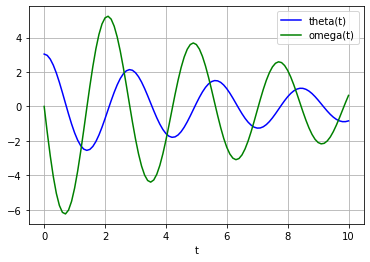

In [68]:
plot(t, sol[:, 0], 'b', label='theta(t)')
plot(t, sol[:, 1], 'g', label='omega(t)')
legend(loc='best')
xlabel('t')
grid()




# With forcing

$$ \frac{d^2 y}{dt^2} +b \frac{d y}{dt} +c y = f_{ext}(t)$$

In [212]:
def pendf(y, t, b, c, duration):
    theta, omega = y
    dydt = [omega, -b*omega - c*theta + f_ext(t, duration)]
    return dydt

b = 0.25
c = 5.0

#initial conditions
y0 = [0.0, 0.0]

# time vector at which to calculate the solution
t = np.linspace(-1,10,101)

# Forcing
def f_ext(t, duration=1):
    if t<0:
        return 0.
    if t<duration:
        return 1.
    else:
        return 0

How does the free state solution (once the forcing is finished) depend on the duration of the forcing?

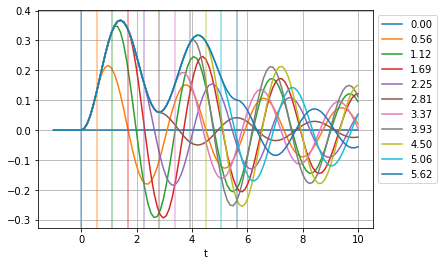

In [213]:
for duration in np.linspace(0,4*np.pi/np.sqrt(c),11):
    sol = odeint(pendf, y0, t, args=(b, c, duration))
    lns=plot(t, sol[:, 0], label='{:.2f}'.format(duration))
    axvline(duration,color=lns[0].get_color(),alpha=.5)
    legend(loc='upper left',bbox_to_anchor=(1,1))
    xlabel('t')
    grid()




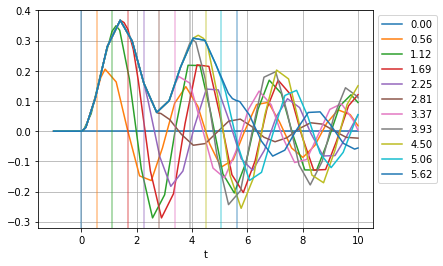

In [214]:
from scipy.integrate import solve_ivp

def pendf_t(t,y,*args):
    return pendf(y,t,*args)

for duration in np.linspace(0,4*np.pi/np.sqrt(c),11):
    sol = solve_ivp(pendf_t, [np.min(t),np.max(t)], y0, args=(b, c, duration))
    lns=plot(sol.t, sol.y[0,:], label='{:.2f}'.format(duration))
    axvline(duration,color=lns[0].get_color(),alpha=.5)
    legend(loc='upper left',bbox_to_anchor=(1,1))
    xlabel('t')
    grid()


In [215]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 446
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([-1.00000000e+00, -9.99999000e-01, -9.99989000e-01, -9.99889000e-01,
       -9.98889000e-01, -9.88889000e-01, -8.88889000e-01, -6.88889000e-01,
       -4.88889000e-01, -3.57046040e-01, -2.25203079e-01, -3.14406754e-02,
       -8.07175557e-04,  1.39802291e-02,  2.73639371e-02,  1.61201017e-01,
        5.07229206e-01,  9.39066465e-01,  1.40597092e+00,  1.83582500e+00,
        2.26001936e+00,  2.72387120e+00,  3.17283714e+00,  3.58455683e+00,
        4.04115539e+00,  4.46455806e+00,  4.86154515e+00,  5.31203933e+00,
        5.46062755e+00,  5.60921577e+00,  5.61909388e+00,  5.62897199e+00,
        5.63799826e+00,  5.72826093e+00,  6.07306382e+00,  6.50454780e+00,
        6.91559116e+00,  7.35301709e+00,  7.76339851e+00,  8.20091111e+00,
        8.62896991e+00,  9.02438012e+00,  9.46611159e+00,  9.87588369e+

# One acoustic mode

$$ \frac{d^2 p}{dt^2} + \frac{\omega_0}{Q} \frac{d p}{dt} + \omega_0^2 p = \frac{Z_0 \omega_0}{Q}  \frac{d u}{dt}$$

In [298]:
from scipy.special import expit

def f(y, t, omega_0, Q, Z_0, duration):
    p, dp = y
    dydt = [dp, - omega_0/Q * dp - omega_0**2*p + Z_0*omega_0/Q * du_ext(t, duration=duration)]
    return dydt

def u_ext(t, duration=1, t_trans=0.001):
    # a sigmoid-based step function
    return (expit(t/t_trans)+expit((duration-t)/t_trans)-1)

def dexpit_f(x):
    if x>10:
        return 0.
    elif x<-10:
        return 0.
    else:
        return exp(-x)/(1+exp(-x))**2

dexpit = vectorize(dexpit_f)

def du_ext_gen(t, duration=1, t_trans=0.001, t_0=0.0):
    return (dexpit((t-t_0)/t_trans)-dexpit((duration-t+t_0)/t_trans))/t_trans

from functools import partial


In [299]:
partial?

Init signature: partial(self, /, *args, **kwargs)
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.
File:           /usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/functools.py
Type:           type
Subclasses:     


In [300]:
figure()

tt = np.linspace(-1,2,301)
plot(tt,du_ext(tt,t_trans=0.1))
plot(tt,du_ext(tt,t_trans=0.01))
plot(tt,du_ext(tt,t_trans=0.01,duration=0.2))

NameError: name 't0' is not defined

<Figure size 432x288 with 0 Axes>

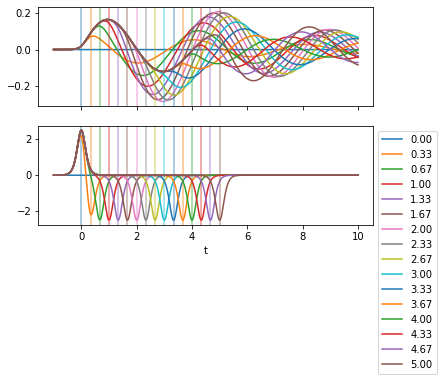

In [301]:
omega_0 = 2*pi/4
q=5
z0=1.0

du_ext = partial(du_ext_gen, t_trans=0.1)

# time vector at which to calculate the solution
t = np.linspace(-1,10,10001)

fig, ax = subplots(2, sharex=True)

def f_t(t,y,*args):
    print(args)
    return f(y,t,*args)

for duration in np.linspace(0,5,16):
    sol = odeint(f, y0, t, args=(omega_0, q, z0, duration))
    #sol = solve_ivp(f_t, [np.min(t), np.max(t)], y0, args=(omega_0, q, z0, duration), method='BDF')
    lns = ax[0].plot(t, sol[:, 0], label='{:.2f}'.format(duration))
    #lns = ax[0].plot(sol.t, sol.y[ 0, :], label='{:.2f}'.format(duration))
    ax[1].plot(t,du_ext(t,duration=duration), label='{:.2f}'.format(duration),color=lns[0].get_color())
    for axi in ax:
        axi.axvline(duration,color=lns[0].get_color(),alpha=.5)
    legend(loc='upper left',bbox_to_anchor=(1,1))
    xlabel('t')
    grid()


## using sympy and separating solvers for forcing and non-forcing periods

In [525]:
import sympy as sy
from sympy.parsing.sympy_parser import parse_expr

base_expr = parse_expr("(1-cos((x-x0)*pi/duration))")
#base_expr = parse_expr("sin((x-x0)*pi/duration)**2")
#expit = parse_expr("exp(-x)/(1+exp(-x))")

#base_expr = expit.subs('x',parse_expr("(x-x0)/t_trans"))+expit.subs('x',parse_expr("(duration-x+x0)/t_trans"))

duration = 0.5
t_start = 1.0
t_end = t_start + duration
t_max = 10.0

t_trans=0.004

base_expr = base_expr.subs({'duration':duration,'x0':t_start,'t_trans':t_trans})

fsy = sy.lambdify('x',base_expr)
dfsy = sy.lambdify('x',base_expr.diff())

In [526]:
base_expr.diff()

2.0*pi*sin(pi*(2.0*x - 2.0))

Text(0.5, 0, 't')

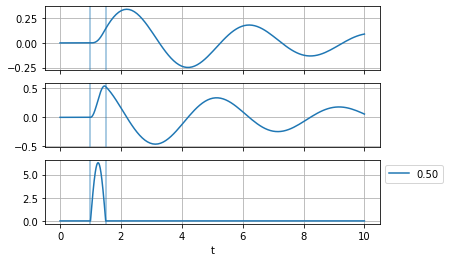

In [527]:
from scipy.integrate import ode
from functools import partial


du_ext = dfsy


def f_off(y, t, omega_0, Q, Z_0):
    p, dp = y
    dydt = [dp, - omega_0/Q * dp - omega_0**2*p ]
    return dydt

def f_on(y, t, omega_0, Q, Z_0):
    p, dp = y
    dydt = [dp, - omega_0/Q * dp - omega_0**2*p + Z_0*omega_0/Q * du_ext(t)]
    return dydt


t0 = np.linspace(0,t_start,100)
sol0 = odeint(f_off, y0, t0, args=(omega_0, q, z0))
force0 = np.zeros(t0.shape)

y1 = sol0[-1]
t1 = np.linspace(t_start,t_end,100)
sol1 = odeint(f_on, y1, t1, args=(omega_0, q, z0))
force1 = du_ext(t1)

y2 = sol1[-1]

t2 = np.linspace(t_end,t_max,100)
sol2 = odeint(f_off, y2, t2, args=(omega_0, q, z0))
force2 = np.zeros(t2.shape)

t = np.concatenate((t0,t1,t2))
y = np.concatenate((sol0,sol1,sol2))
force = np.concatenate((force0,force1,force2))

fig,ax = plt.subplots(3,sharex=True)

#sol = solve_ivp(f_t, [np.min(t), np.max(t)], y0, args=(omega_0, q, z0, duration), method='BDF')
lns = ax[0].plot(t, y[:, 0], label='{:.2f}'.format(duration))
lns = ax[1].plot(t, y[:, 1], label='{:.2f}'.format(duration),color=lns[0].get_color())
ax[-1].plot(t,force, label='{:.2f}'.format(duration),color=lns[0].get_color())
for axi in ax:
    axi.axvline(t_start,color=lns[0].get_color(),alpha=.5)
    axi.axvline(t_end,color=lns[0].get_color(),alpha=.5)
    axi.grid(True)
legend(loc='upper left',bbox_to_anchor=(1,1))
xlabel('t')

#xlim(t_start-duration,t_end+duration)

# Two modes

In [1375]:
import sympy as sy
from sympy.parsing.sympy_parser import parse_expr

base_expr = parse_expr("(1-cos((x-x0)*pi/duration))")
#base_expr = parse_expr("((x-x0)/duration)")

#base_expr = parse_expr("sin((x-x0)*pi/duration)**2")
#expit = parse_expr("exp(-x)/(1+exp(-x))")

#base_expr = expit.subs('x',parse_expr("(x-x0)/t_trans"))+expit.subs('x',parse_expr("(duration-x+x0)/t_trans"))

duration = 2.5
t_start = 1.0
t_end = t_start + duration
t_max = 1000.0

omega_1 = 2*pi/4
q1=-20
z1=1.0

omega_2 = 2.2*pi/4
q2=-10
z2=1.0

t_trans=0.004

base_expr = base_expr.subs({'duration':duration,'x0':t_start,'t_trans':t_trans})

fsy = sy.lambdify('x',base_expr,'numpy')
if base_expr.diff().is_constant():
    dfsy = np.vectorize(lambda x:  base_expr.diff() )
else:
    dfsy = sy.lambdify('x',base_expr.diff(),'numpy')

In [1376]:
dfsy(np.linspace(0,duration,10))

array([-1.19513287, -0.99024352, -0.66591619, -0.26126954,  0.17489008,
        0.58995537,  0.93386333,  1.16513359,  1.25587155,  1.19513287])

/Users/goios/Envs/unsw/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


(-6.0, 6.0)

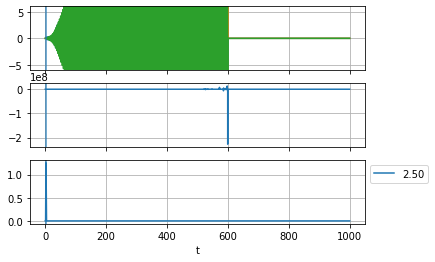

In [1377]:
from scipy.integrate import ode
from functools import partial


du_ext = dfsy
qch=5
psat=5

dpfp_expr = parse_expr("- omega / q * dp - dp_tot *(p_tot/p_sat)**2 - omega **2 * p")
#dpfp_expr = parse_expr("- omega / q * dp + dp_tot / (1+(p_tot/p_sat)**2)  - omega **2 * p")
forcing_expr = parse_expr(" Z0 * omega / abs(q) * du")
# dpfp1 = sy.lambdify('p,dp', dpfp_expr.subs({'omega':omega_1, 'q':Q1, 'p_sat':psat}))
# dpfp2 = sy.lambdify('p,dp', dpfp_expr.subs({'omega':omega_2, 'q':Q2, 'p_sat':psat}))
dpfp = sy.lambdify('p,dp,p_tot,dp_tot,omega,q,p_sat', dpfp_expr)
forcing = sy.lambdify('du,omega,q,Z0', forcing_expr)

def f_off(y, t, omega_1, Q1, Z_1, omega_2, Q2, Z_2):
    p1, dp1, p2, dp2 = y
    dydt = [dp1, dpfp(p1,dp1,p2+p1,dp2+dp1,omega_1,Q1,psat),
            dp2, dpfp(p2,dp2,p1+p2,dp1+dp2,omega_2,Q2,psat)]
#     dydt = [dp1, (- omega_1/Q1 * dp1 * (1-(dp1/qch)**2) - omega_1**2*p1),
#             dp2, (- omega_2/Q2 * dp2 * (1-(dp2/qch)**2) - omega_2**2*p2)]
    return dydt

def f_on(y, t, omega_1, Q1, Z_1, omega_2, Q2, Z_2):
    p1, dp1, p2, dp2 = y
    dydt = [dp1, dpfp(p1,dp1,p1+p2,dp1+dp2,omega_1,Q1,psat) + forcing(du_ext(t),omega_1,Q1, Z_1),
            dp2, dpfp(p2,dp2,p1+p2,dp1+dp2,omega_2,Q2,psat) + forcing(du_ext(t),omega_2,Q2, Z_2)]
    return dydt

y0 = [0.0,0.0,0.0,0.0]
args = (omega_1,q1,z1,omega_2,q2,z2)

t0 = np.linspace(0,t_start,100)
sol0 = odeint(f_off, y0, t0, args=args)
force0 = np.zeros(t0.shape)

y1 = sol0[-1]
t1 = np.linspace(t_start,t_end,100)
sol1 = odeint(f_on, y1, t1, args=args)
force1 = du_ext(t1)

y2 = sol1[-1]

t2 = np.linspace(t_end,t_max,10000)
sol2 = odeint(f_off, y2, t2, args=args)
force2 = np.zeros(t2.shape)

t = np.concatenate((t0,t1,t2))
y = np.concatenate((sol0,sol1,sol2))
ys = vstack((y[:,0]+y[:,2],y[:,1]+y[:,3])).T
force = np.concatenate((force0,force1,force2))

fig,ax = plt.subplots(3,sharex=True)

#sol = solve_ivp(f_t, [np.min(t), np.max(t)], y0, args=(omega_0, q, z0, duration), method='BDF')
lns = ax[0].plot(t, ys[:, 0], label='ptot')
ax[0].plot(t,y[:,0],label='p1')
ax[0].plot(t,y[:,2],label='p2')

lns = ax[1].plot(t, ys[:, 1], label='{:.2f}'.format(duration),color=lns[0].get_color())
ax[-1].plot(t,force, label='{:.2f}'.format(duration),color=lns[0].get_color())
for axi in ax:
    axi.axvline(t_start,color=lns[0].get_color(),alpha=.5)
    axi.axvline(t_end,color=lns[0].get_color(),alpha=.5)
    axi.grid(True)
legend(loc='upper left',bbox_to_anchor=(1,1))
xlabel('t')

#xlim(t_start-duration,t_end+duration)
ax[0].set_ylim([-6,6])
#xlim(800,900)

In [1378]:
dp1,dp2,p1,p2 = sy.symbols('dp1,dp2,p1,p2')
dydtvec =  sy.Matrix([dp1, dpfp(p1,dp1,p1+p2,dp1+dp2,omega_1,q1,psat),
                      dp2, dpfp(p2,dp2,p1+p2,dp1+dp2,omega_2,q2,psat)])
dydtjac = dydtvec.jacobian([p1,dp1,p2,dp2])
P1, P2 = sy.symbols('P1,P2')
s = sy.symbols('s')
dydtjacs=dydtjac.subs({p1:0,dp1:0,p2:0,dp2:0})
svals=[x for x in dydtjacs.eigenvals().keys()]
forcingvec = sy.Matrix([0, forcing(1,omega_1,q1, z1),
                        0, forcing(1,omega_2,q2, z2)])

In [1379]:
(dydtjac.subs({dp1:s*p1,dp2:s*p2}).inv()*forcingvec).subs({p1:0,p2:0})

Matrix([
[-0.0318309886183791],
[                  0],
[-0.0578745247606892],
[                  0]])

In [1380]:
dydtvec

Matrix([
[                                                                       dp1],
[0.0785398163397448*dp1 - 2.46740110027234*p1 - (dp1 + dp2)*(p1 + p2)**2/25],
[                                                                       dp2],
[ 0.172787595947439*dp2 - 2.98555533132953*p2 - (dp1 + dp2)*(p1 + p2)**2/25]])

In [1381]:
chpolys = sy.Matrix([s,s**2,s,s**2]) - dydtjacs*sy.Matrix([1,s,1,s])
chpolys

Matrix([
[                                             0],
[s**2 - 0.0785398163397448*s + 2.46740110027234],
[                                             0],
[ s**2 - 0.172787595947439*s + 2.98555533132953]])

In [1382]:
svals2=[np.roots(sy.Poly(x,s).coeffs()) for x in sy.Matrix([s,s**2,s,s**2]) - dydtjacs*sy.Matrix([1,s,1,s])]

In [1383]:
svals2

[array([], dtype=float64),
 array([0.03926991+1.57030538j, 0.03926991-1.57030538j]),
 array([], dtype=float64),
 array([0.0863938+1.72571476j, 0.0863938-1.72571476j])]

(-1.0, 1.0)

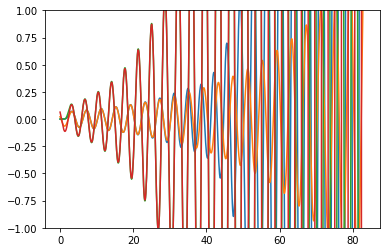

In [1384]:
figure()
N=1000
imp_mag = base_expr.diff().integrate(('x',0,duration))
plot(t[:N],y[:N,0])
s1 = svals2[1][0]
x1 = complex(forcingvec[1])/s1 * complex(sy.Integral(base_expr.diff()*parse_expr("exp({:f}*(x-{:f}))".format(s1,t_start)),('x',t_start,t_start+duration)).evalf())
s2 = svals2[3][1]
x2 = complex(forcingvec[3])/s2 * complex(sy.Integral(base_expr.diff()*parse_expr("exp({:f}*(x-{:f}))".format(s2,t_start)),('x',t_start,t_start+duration)).evalf())
plot(t[:N],np.real(x1*exp(s1*(t[:N]-t_start-duration))))
plot(t[:N],y[:N,2])
plot(t[:N],np.real(x2*exp(s2*(t[:N]-t_start-duration))))
ylim(-1,1)

In [1248]:
sy.Integral(base_expr.diff('x',1)*parse_expr("exp({:f}*x)".format(svals2[1][0])),('x',t_start,t_start+duration)).evalf()

-1.63396338609911 + 0.001605620503741*I

In [1247]:
base_expr.diff()

pi*sin(pi*(x/2 - 0.5))/2

In [1139]:
np.roots([1,1,-1])

array([-1.61803399,  0.61803399])

/Users/goios/Envs/unsw/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


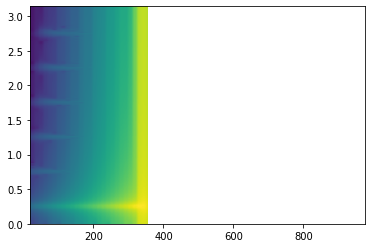

/Users/goios/Envs/unsw/lib/python3.8/site-packages/ipykernel/pylab/backend_inline.py:183: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  for label in axis.get_ticklabels()])


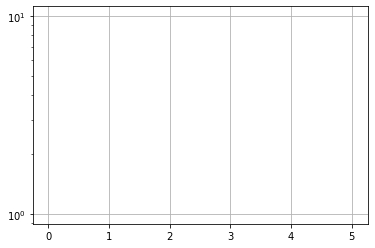

In [1319]:
figure()
dt = np.median(np.diff(t)[-10:])
ti = np.arange(np.min(t),np.max(t),dt)
yi = np.interp(ti,t,y[:,0])
spectrum,freqs,tspec,*_ =specgram(yi,Fs=1/dt,NFFT=2**9,noverlap=2**9-2**7)
ylim(0,max(omega_1,omega_2)*2)
figure()
semilogy(freqs,spectrum[:,-1])
grid()

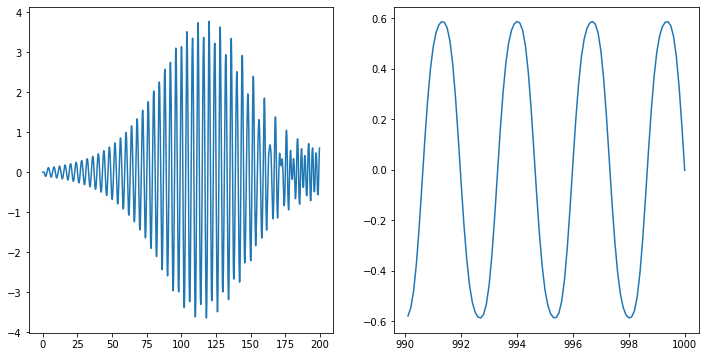

In [1049]:
fig,ax=subplots(1,2,figsize=(12,6))
Nbeg=2000
ax[0].plot(ti[:Nbeg],yi[:Nbeg])
ax[1].plot(ti[-100:],yi[-100:])

In [1012]:
zstr = "d_{0}*x/(a_{0}*x**2+b_{0}*x+c_{0})"
zvsym = parse_expr(zstr.format("v"))
zbsym = parse_expr(zstr.format("b"))
sresp = 1/(1+parse_expr("k")*(zvsym+zbsym))
sy.apart(sresp)

NotImplementedError: multivariate partial fraction decomposition

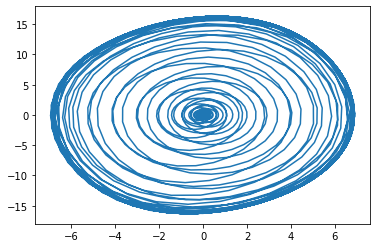

In [971]:
figure()
plot(y[:,0],y[:,1])

In [518]:
def f_t(t, y, omega_0, Q, Z_0, duration):
    p, dp = y
    dydt = [dp, - omega_0/Q * dp - omega_0**2*p + Z_0*omega_0/Q * du_ext(t, duration=duration)]
    return dydt

omega_0 = np.pi/2
q = 5.0
z0=1.0
duration=1.0

t = np.linspace(0,10,10001)

solver = ode(f_t).set_integrator('vode',method='bdf')
solver.set_initial_value(y0, min(t))
solver.set_f_params(omega_0, q, z0, duration)

t1 = 10

dt = 1

du_ext = partial(du_ext_gen, t_trans=0.01, t_0=1.0)

sol = np.zeros((len(t),len(y0)))

newt=[]

for ii,this_t in enumerate(t[1:]):
    newt.append(this_t)
    sol[ii,:]=solver.integrate(this_t,step=0.001)
    if not solver.successful():
        print('Failed at time {:.3f} (code {})'.format(this_t,solver.get_return_code()))
        break

Failed at time 0.314 (code -5)


/Users/goios/Envs/unsw/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


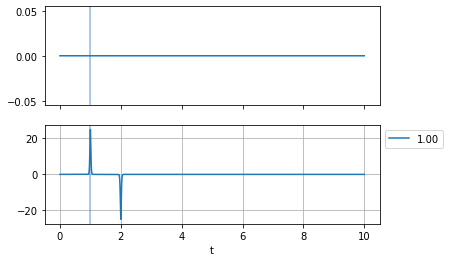

In [356]:
fig, ax = subplots(2, sharex=True)

lns = ax[0].plot(t, sol[:, 0], label='{:.2f}'.format(duration))
ax[1].plot(t,du_ext(t,duration=duration), label='{:.2f}'.format(duration),color=lns[0].get_color())
for axi in ax:
    axi.axvline(duration,color=lns[0].get_color(),alpha=.5)
legend(loc='upper left',bbox_to_anchor=(1,1))
xlabel('t')
grid()


# Two acoustic modes

$$ \frac{1}{\omega_1^2}\frac{d^2 p_1}{dt^2} + \frac{\omega_1}{Q_1} \frac{d p_1}{dt} + \omega_1^2 p_1 + \frac{d^2 p_2}{dt^2} + \frac{\omega_2}{Q_2} \frac{d p_2}{dt} + \omega_2^2 p_2 = \frac{Z_0 \omega_0}{Q}  \frac{d u}{dt}$$